# Image Colorization & Enhancement using DeOldify

**Overview**:

This project uses DeOldify, a deep learning model based on Generative Adversarial Networks (GANs), to colorize and enhance black & white images. The project is implemented in Google Colab and supports both image uploads and online image processing via URLs.

**Features:**

*   Convert grayscale images to color using DeOldify’s pre-trained models.
*   Enhance image quality after colorization using contrast and brightness
adjustments.
*   Upload images manually or provide an image URL.
*   Side-by-side comparison of original grayscale vs. colorized vs. enhanced images.
*   Fast execution using Google Colab with GPU support.







**Step 1: Clone DeOldify Repository & Install Dependencies and Download Pre-trained models**

In [4]:
!git clone https://github.com/jantic/DeOldify.git DeOldify
%cd DeOldify
!pip install -r requirements-colab.txt
#Download Pre-trained Model
!mkdir 'models'
!wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth


Cloning into 'DeOldify'...
remote: Enumerating objects: 2620, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 2620 (delta 64), reused 46 (delta 46), pack-reused 2514 (from 3)
Receiving objects: 100% (2620/2620), 69.73 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (1174/1174), done.
/content/DeOldify
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 30.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.2

mkdir: cannot create directory ‘models’: File exists
--2025-03-07 05:26:43--  https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth
Resolving data.deepai.org (data.deepai.org)... 143.244.50.214, 2400:52e0:1a01::1114:1
Connecting to data.deepai.org (data.deepai.org)|143.244.50.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255144681 (243M) [application/octet-stream]
Saving to: ‘./models/ColorizeArtistic_gen.pth’

./models/ColorizeAr 100%[===================>] 243.32M  4.98MB/s    in 50s     

2025-03-07 05:27:32 (4.91 MB/s) - ‘./models/ColorizeArtistic_gen.pth’ saved [255144681/255144681]



**Step 2: Import Required Libraries and check for GPU**

In [5]:
import torch
import time
import cv2
import numpy as np
import requests
from deoldify.visualize import get_image_colorizer
from PIL import Image
from IPython.display import display
from io import BytesIO
import os
from google.colab import files  # For file upload

# ✅ Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load DeOldify colorizer (artistic mode for high-quality results)
colorizer = get_image_colorizer(artistic=True)  # ✅ Removed .to(device) to fix error


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


NumExpr defaulting to 2 threads.


/content/DeOldify/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/content/DeOldify/fastai/data_block.py:453: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  warn("""Your validation set is empty. If this is by design, use `split_none()`
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  wa

In [6]:
#  Function to download an image from a URL
def download_image(url, save_path="input.jpg"):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, "wb") as f:
            f.write(response.content)
        return save_path
    else:
        print("Error: Unable to download image.")
        return None

In [7]:
# Function to apply Histogram Equalization for better contrast
def enhance_image(image_path):
    img = cv2.imread(image_path)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_eq = cv2.equalizeHist(l)
    lab_eq = cv2.merge((l_eq, a, b))
    enhanced_img = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    enhanced_path = "enhanced_" + image_path
    cv2.imwrite(enhanced_path, enhanced_img)
    return enhanced_path

In [8]:
#  Function to process & display an image
def process_image(image_path, enhance=False):
    start_time = time.time()

    # Colorize the image
    result_path = colorizer.plot_transformed_image(image_path, render_factor=45, display_render_factor=True)

    # Apply enhancement
    if enhance:
        result_path = enhance_image(result_path)

    # Display the final image
    display(Image.open(result_path))

    print(f"✅ Processing Time: {time.time() - start_time:.2f} seconds")
    return result_path

In [9]:
import matplotlib.pyplot as plt

# Function to display a side-by-side comparison
def show_comparison(original_path, colorized_path, enhanced_path=None):
    # Load images
    original = Image.open(original_path).convert("L")  # Convert to grayscale
    colorized = Image.open(colorized_path)

    # Create subplot layout
    fig, axes = plt.subplots(1, 3 if enhanced_path else 2, figsize=(15, 5))

    # Display original grayscale image
    axes[0].imshow(original, cmap="gray")
    axes[0].set_title("Grayscale Image")
    axes[0].axis("off")

    # Display colorized image
    axes[1].imshow(colorized)
    axes[1].set_title("Colorized Image")
    axes[1].axis("off")

    # Display enhanced image (if available)
    if enhanced_path:
        enhanced = Image.open(enhanced_path)
        axes[2].imshow(enhanced)
        axes[2].set_title("Enhanced Image")
        axes[2].axis("off")

    plt.show()


#  Updated process_image() function
def process_image(image_path, enhance=False):
    start_time = time.time()

    # Step 1: Colorize Image
    colorized_path = colorizer.plot_transformed_image(image_path, render_factor=45, display_render_factor=False)

    # Step 2: Enhance Image (if required)
    enhanced_path = None
    if enhance:
        enhanced_path = enhance_image(colorized_path)

    # Step 3: Display Side-by-Side Comparison
    show_comparison(image_path, colorized_path, enhanced_path)

    print(f"✅ Processing Time: {time.time() - start_time:.2f} seconds")
    return colorized_path if not enhance else enhanced_path


In [10]:
# Function to apply Histogram Equalization for better contrast
def enhance_image(image_path):
    img = cv2.imread(image_path)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_eq = cv2.equalizeHist(l)
    lab_eq = cv2.merge((l_eq, a, b))
    enhanced_img = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    #Updated enhanced_path for subdirectory
    enhanced_path = os.path.join(os.path.dirname(image_path), "enhanced_" + os.path.basename(image_path))
    cv2.imwrite(enhanced_path, enhanced_img)
    return enhanced_path

**Image Processing:**

**Upload an immage manually**

Saving black__white_face_girl_model_margot_robbie_4k_5k_hd_girls.jpg to black__white_face_girl_model_margot_robbie_4k_5k_hd_girls.jpg
Uploaded File: black__white_face_girl_model_margot_robbie_4k_5k_hd_girls.jpg


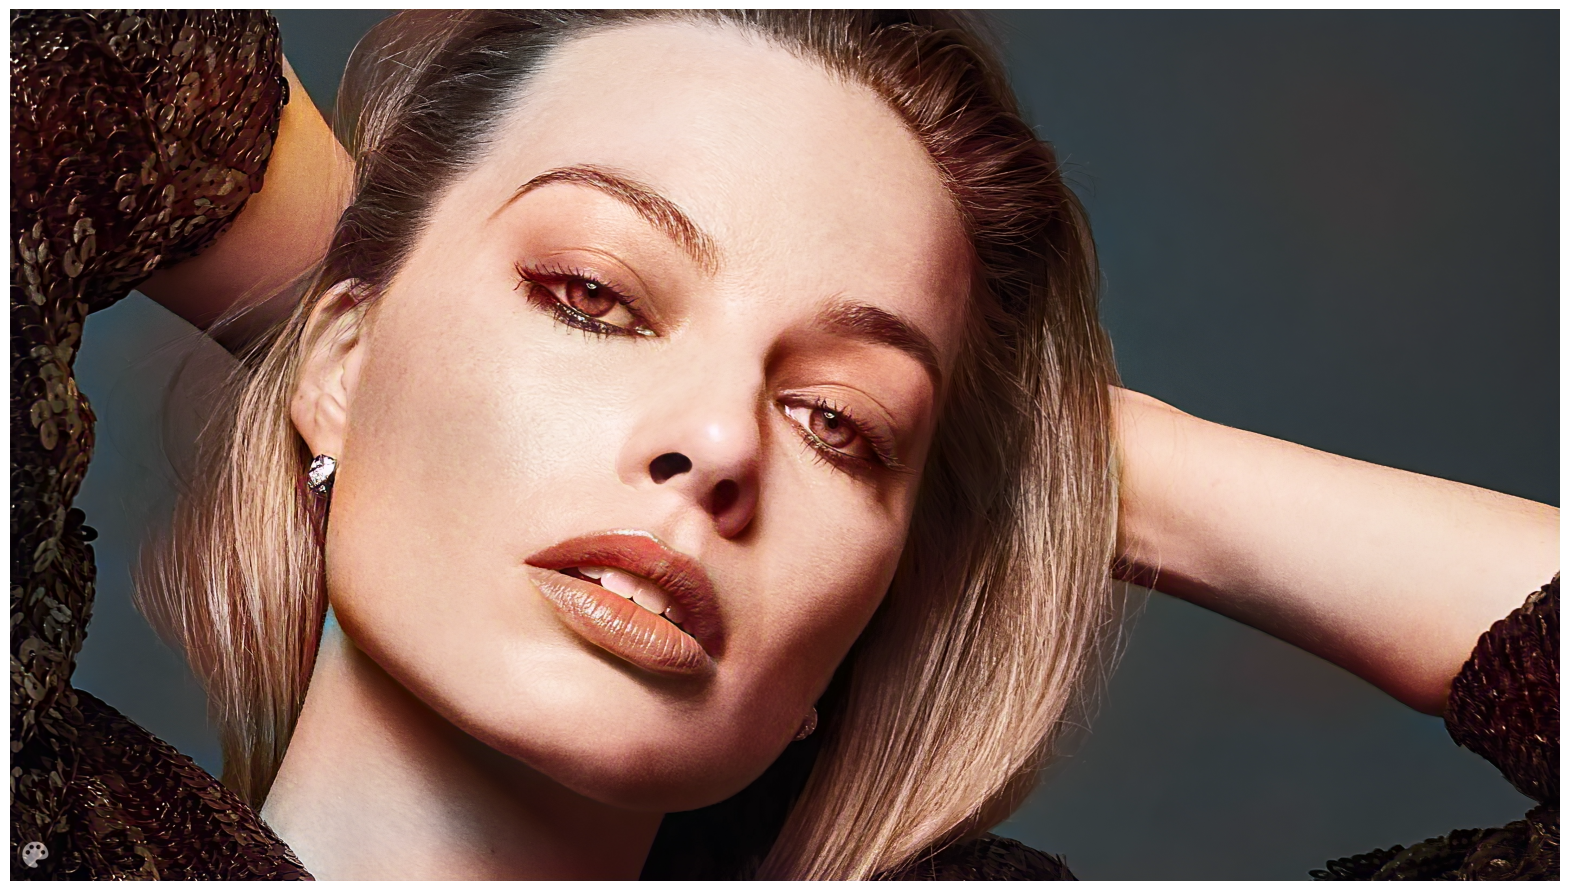

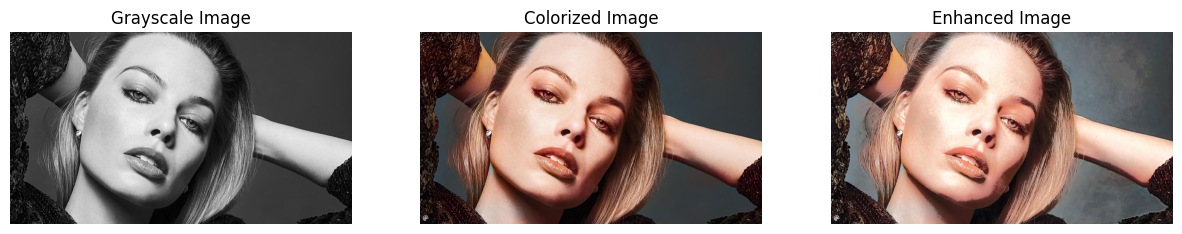

✅ Processing Time: 55.90 seconds


In [11]:
# Upload an image manually
uploaded = files.upload()

# Get uploaded filename
for filename in uploaded.keys():
    print(f"Uploaded File: {filename}")
    colorized_image = process_image(filename, enhance=True)

**Download an Image from a URL**

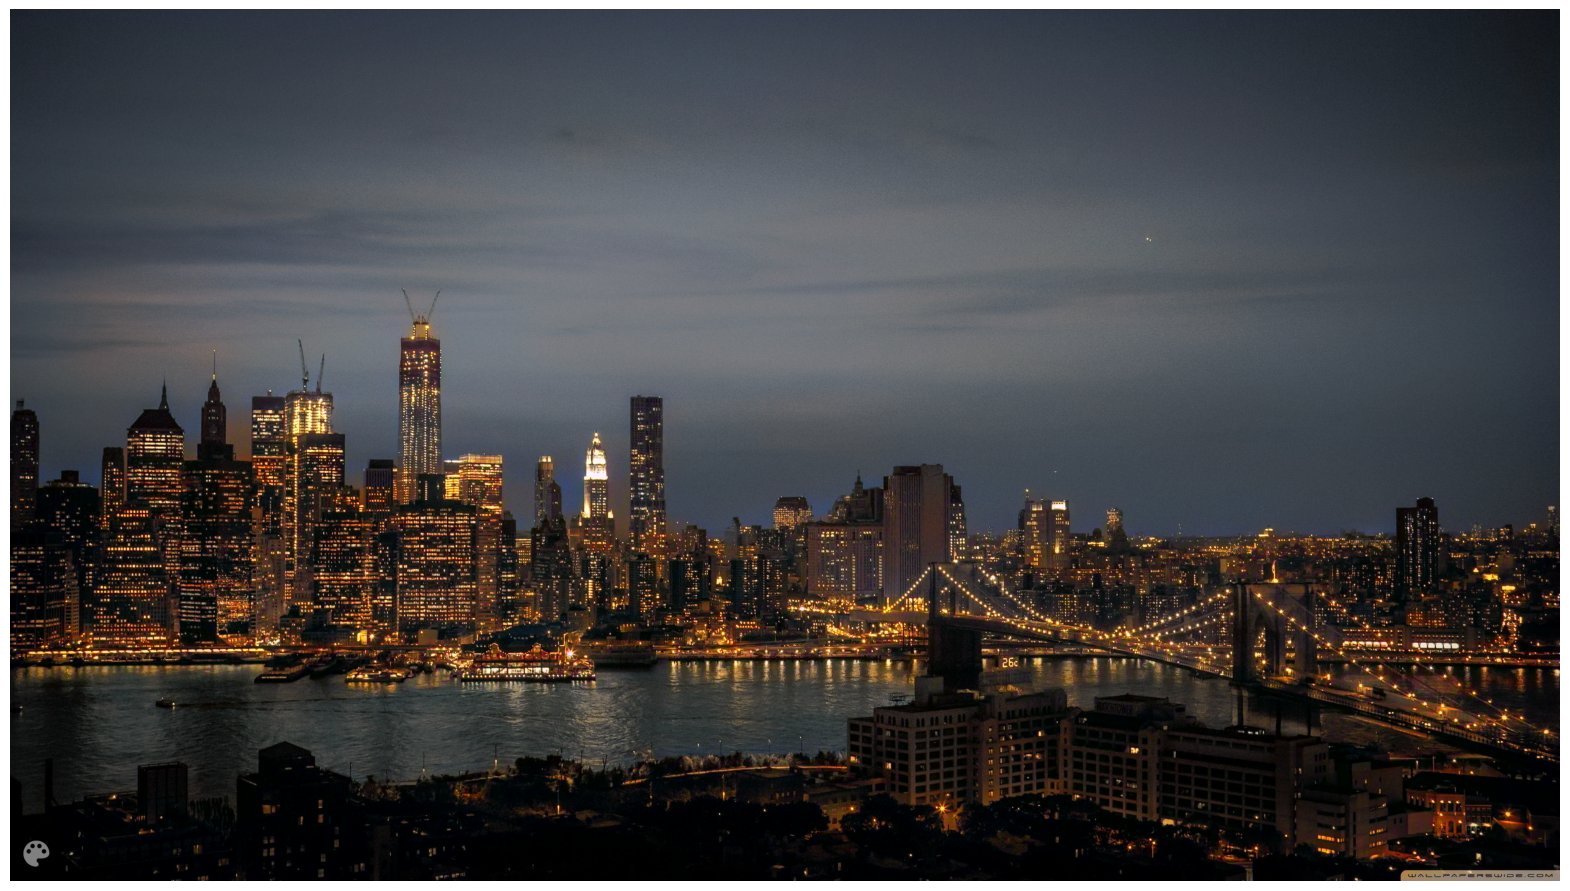

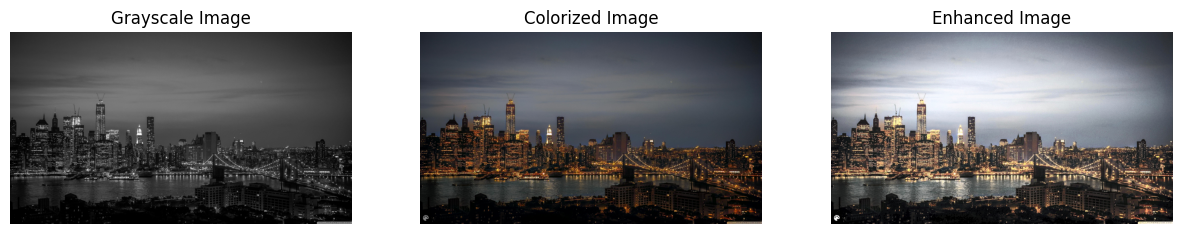

✅ Processing Time: 55.63 seconds


In [11]:
def download_image(url, save_path="input.jpg"):
    import requests
    from pathlib import Path
    response = requests.get(url)
    if response.status_code == 200:
        save_path = Path(save_path)
        save_path.write_bytes(response.content)
        return str(save_path)
    else:
        print("Error: Unable to download image.")
        return None

image_url = "https://wallpapercave.com/wp/wp4220069.jpg"
input_image = download_image(image_url)
if input_image:
    process_image(input_image, enhance=True)